# Steering Prediction Model 

## Environment Setup

In [1]:
import os
import random
import fnmatch
import datetime
import pickle

import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


tf.__version__: 2.6.0
keras.__version__: 2.6.0


## Preparation of data and path

In [2]:
data_dir = ["../ccnn_output_sullychen","../lanenet_output_sullychen"]
sublist = ['/binary_image/','/instance_image/']
imgtxt_list,cb_list,ci_list,lb_list,li_list,o_list = [],[],[],[],[],[]
steer_angle_list = []

with open('../SullyChen/data.txt') as f:
    lines = f.readlines()
f.close()
for i in lines:
    steer_angle_list.append(float(i.split()[1][0:5]))
    imgtxt_list.append(i[0:i.find('.jpg')+4])
    cb_list.append(data_dir[0]+sublist[0]+i[0:i.find('.jpg')+4])
    ci_list.append(data_dir[0]+sublist[1]+i[0:i.find('.jpg')+4])
    lb_list.append(data_dir[1]+sublist[0]+i[0:i.find('.jpg')+4])
    li_list.append(data_dir[1]+sublist[1]+i[0:i.find('.jpg')+4])
    o_list.append('../SullyChen/data/'+i[0:i.find('.jpg')+4])

In [3]:
df_ci,df_cb,df_li,df_lb,df_o = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
df_ci['Imagepath'],df_cb['Imagepath'],df_li['Imagepath'],df_lb['Imagepath'] = ci_list,cb_list,li_list,lb_list
df_o['Imagepath'] = o_list
df_ci['Angle'],df_cb['Angle'],df_li['Angle'],df_lb['Angle'],df_o['Angle'] = steer_angle_list,steer_angle_list,steer_angle_list,steer_angle_list,steer_angle_list

## Exploratory Data analysis on road image and angle

image_path: ../lanenet_output_sullychen/binary_image/20.jpg
steering_Angle: 0


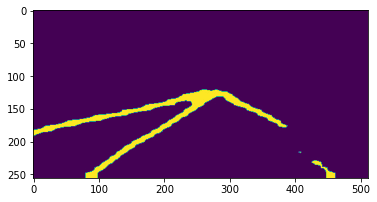

In [18]:
# Sample visualisation of output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
image_index = 20
plt.imshow(Image.open(lb_list[image_index]))
print("image_path: %s" % lb_list[20] )
print("steering_Angle: %d" % steer_angle_list[image_index] )

In [4]:
df = pd.DataFrame()
df['Imagepath'] = imgtxt_list
df['Angle'] = steer_angle_list

(array([3.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.0000,
        0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        2.0000, 0.0000, 0.0000, 0.0000, 1.0000, 2.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 2.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 2.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 4.0000, 2.0000, 15.0000, 8.0000, 1.0000, 11.0000,
        11.0000, 5.0000, 5.0000, 6.0000, 2.0000, 4.0000, 1.0000, 3.0000,
        4.0000, 2.0000, 2.0000, 2.0000, 2.0000, 12.0000, 7.00

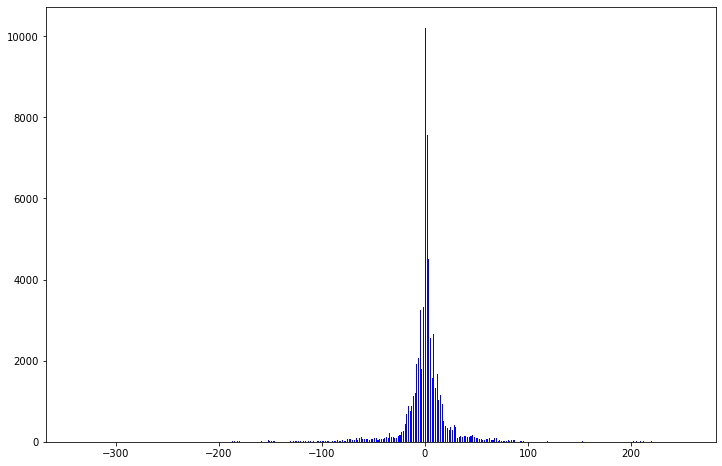

In [14]:
#Angle distribution
num_of_bins = 360
samples_per_bin = 100
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,8))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

## Model training

### train-test-valid split

In [5]:
random.seed(34)
X_train_lb, X_test_lb, y_train_lb, y_test_lb = train_test_split(lb_list, steer_angle_list, test_size=0.15,random_state=34)
X_train_lb, X_valid_lb, y_train_lb, y_valid_lb = train_test_split(X_train_lb, y_train_lb, test_size=3/17, random_state=34)
X_train_li, X_test_li, y_train_li, y_test_li = train_test_split(li_list, steer_angle_list, test_size=0.15,random_state=34)
X_train_li, X_valid_li, y_train_li, y_valid_li = train_test_split(X_train_li, y_train_li, test_size=3/17, random_state=34)
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(cb_list, steer_angle_list, test_size=0.15,random_state=34)
X_train_cb, X_valid_cb, y_train_cb, y_valid_cb = train_test_split(X_train_cb, y_train_cb, test_size=3/17, random_state=34)
X_train_ci, X_test_ci, y_train_ci, y_test_ci = train_test_split(ci_list, steer_angle_list, test_size=0.15,random_state=34)
X_train_ci, X_valid_ci, y_train_ci, y_valid_ci = train_test_split(X_train_ci, y_train_ci, test_size=3/17, random_state=34)
print("Training data: %d\nValidation data: %d" % (len(X_train_lb), len(X_valid_lb)))

Training data: 44677
Validation data: 9574


In [5]:
###test
df = pd.DataFrame()
df['Imagepath'] = X_test_cb
df['Angle'] = y_test_cb
df.to_csv('../angle_prediction/csv_data/test/df_cb_v2.csv', index=False)
df = pd.DataFrame()
df['Imagepath'] = X_test_ci
df['Angle'] = y_test_ci
df.to_csv('../angle_prediction/csv_data/test/df_ci_v2.csv', index=False)
df = pd.DataFrame()
df['Imagepath'] = X_test_lb
df['Angle'] = y_test_lb
df.to_csv('../angle_prediction/csv_data/test/df_lb_v2.csv', index=False)
df = pd.DataFrame()
df['Imagepath'] = X_test_li
df['Angle'] = y_test_li
df.to_csv('../angle_prediction/csv_data/test/df_li_v2.csv', index=False)

In [4]:
random.seed(34)
X_train_o, X_valid_o, y_train_o, y_valid_o = train_test_split(o_list, steer_angle_list, test_size=0.15,random_state=34)
X_train_o, X_valid_o, y_train_o, y_valid_o = train_test_split(X_train_o, y_train_o, test_size=3/17, random_state=34)

### Function to preprocessing data
#### including:
#### 1. Read data
#### 2. Preprocess data with removing height, converting to YUV space, resize and normalizing
#### 3. Batch Data generation

In [6]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [7]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top 0.5 of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # suggested by Nvidia model
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing
    return image


In [11]:
def image_gen_original(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
             
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))
            
            

### Model construction

In [8]:
def build_model():
    model = Sequential()

    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 

    model.add(Flatten())
    model.add(Dropout(0.2)) 
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))

    # output layer: steering angle (0 is straight, <0 turn left, >0 turn right)
    model.add(Dense(1)) 

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [10]:
model=build_model()
print(model.summary())

2021-12-19 03:55:08.442943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 03:55:10.249193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-12-19 03:55:10.257173: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-19 03:55:10.258261: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout (Dropout)            (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

/userhome/cs/tyh002/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### Visualisation of image before training

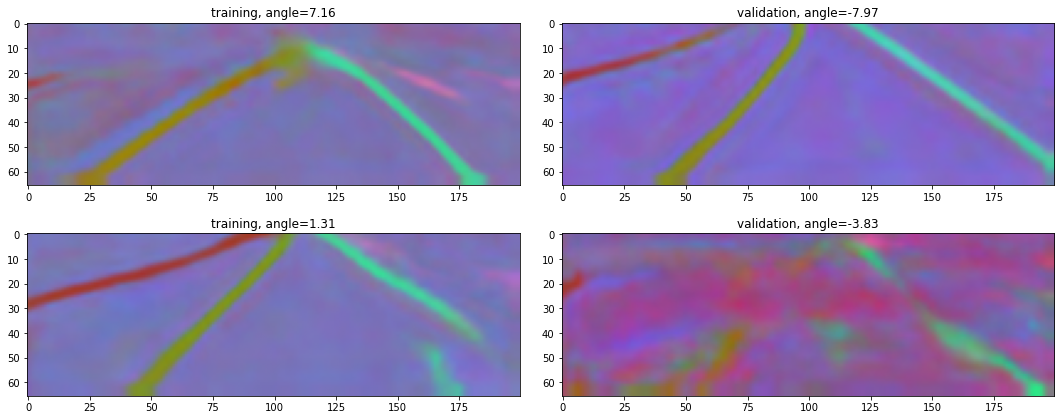

In [14]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_gen_original(X_train_li, y_train_li, nrow))
X_valid_batch, y_valid_batch = next(image_gen_original(X_valid_li, y_valid_li, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

### Train Model

#### Cascaded CNNs binary segmentation image

In [12]:
model = build_model()
model_dir = '../angle_prediction/new'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('../angle_prediction/new/lane_keeping_angle_cb.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_gen_original(X_train_cb, y_train_cb, batch_size=1024),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_gen_original( X_valid_cb, y_valid_cb, batch_size=128),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
model.save(os.path.join(model_dir,'lane_navigation_final_cb.h5'))

history_path = os.path.join(model_dir,'history_cb.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)


Epoch 1/10
300/300 [==============================] - 2946s 10s/step - loss: 444.3756 - val_loss: 488.7931

Epoch 00001: val_loss improved from inf to 488.79309, saving model to ../angle_prediction/new/lane_keeping_angle_cb.h5
Epoch 2/10
300/300 [==============================] - 2338s 8s/step - loss: 310.9409 - val_loss: 486.5861

Epoch 00002: val_loss improved from 488.79309 to 486.58609, saving model to ../angle_prediction/new/lane_keeping_angle_cb.h5
Epoch 3/10
300/300 [==============================] - 2290s 8s/step - loss: 235.9160 - val_loss: 529.9471

Epoch 00003: val_loss did not improve from 486.58609
Epoch 4/10
300/300 [==============================] - 2311s 8s/step - loss: 194.8193 - val_loss: 494.0424

Epoch 00004: val_loss did not improve from 486.58609
Epoch 5/10
300/300 [==============================] - 2296s 8s/step - loss: 151.7042 - val_loss: 451.0501

Epoch 00005: val_loss improved from 486.58609 to 451.05011, saving model to ../angle_prediction/new/lane_keeping_a

#### Cascaded CNNs instance segmenation image

In [12]:
model_dir = '../angle_prediction/new/'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('../angle_prediction/new/lane_keeping_angle_ci.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_gen_original(X_train_ci, y_train_ci, batch_size=1024),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_gen_original( X_valid_ci, y_valid_ci, batch_size=128),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_dir,'lane_navigation_final_ci.h5'))

history_path = os.path.join(model_dir,'history_ci.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)


/userhome/cs/tyh002/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-19 03:56:39.495111: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
300/300 [==============================] - 3656s 12s/step - loss: 451.4243 - val_loss: 224.3111

Epoch 00001: val_loss improved from inf to 224.31113, saving model to ../angle_prediction/new/lane_keeping_angle_ci.h5
Epoch 2/10
300/300 [==============================] - 2923s 10s/step - loss: 125.9298 - val_loss: 87.4391

Epoch 00002: val_loss improved from 224.31113 to 87.43908, saving model to ../angle_prediction/new/lane_keeping_angle_ci.h5
Epoch 3/10
300/300 [==============================] - 2905s 10s/step - loss: 66.5548 - val_loss: 56.2727

Epoch 00003: val_loss improved from 87.43908 to 56.27271, saving model to ../angle_prediction/new/lane_keeping_angle_ci.h5
Epoch 4/10
300/300 [==============================] - 2914s 10s/step - loss: 47.2793 - val_loss: 47.5133

Epoch 00004: val_loss improved from 56.27271 to 47.51331, saving model to ../angle_prediction/new/lane_keeping_angle_ci.h5
Epoch 5/10
300/300 [==============================] - 2920s 10s/step - loss: 40.7783

#### LaneNet instance segmenation image

In [18]:
model=build_model()
model_dir = '../angle_prediction/new/'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('../angle_prediction/new/lane_keeping_angle_li.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_gen_original(X_train_li, y_train_li, batch_size=1024),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_gen_original( X_valid_li, y_valid_li, batch_size=128),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_dir,'lane_navigation_final_li.h5'))

history_path = os.path.join(model_dir,'history_li.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

2021-12-09 16:39:58.119104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 16:39:58.131565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-12-09 16:39:58.133283: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-09 16:39:58.134850: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

Epoch 1/10
300/300 [==============================] - 2907s 10s/step - loss: 398.4547 - val_loss: 226.4401

Epoch 00001: val_loss improved from inf to 226.44008, saving model to ../angle_prediction/new/lane_keeping_angle_li.h5
Epoch 2/10
300/300 [==============================] - 2139s 7s/step - loss: 163.8484 - val_loss: 147.8711

Epoch 00002: val_loss improved from 226.44008 to 147.87114, saving model to ../angle_prediction/new/lane_keeping_angle_li.h5
Epoch 3/10
300/300 [==============================] - 2120s 7s/step - loss: 85.3805 - val_loss: 127.8205

Epoch 00003: val_loss improved from 147.87114 to 127.82053, saving model to ../angle_prediction/new/lane_keeping_angle_li.h5
Epoch 4/10
300/300 [==============================] - 2126s 7s/step - loss: 58.3927 - val_loss: 103.7879

Epoch 00004: val_loss improved from 127.82053 to 103.78795, saving model to ../angle_prediction/new/lane_keeping_angle_li.h5
Epoch 5/10
300/300 [==============================] - 2115s 7s/step - loss: 46.

##### Noted that due to network connection break, the notebook will convert into runnable python file and training of model using LaneNet binary segmentation image and original image will execute via the python file and run on Anaconda to generate model and history.pickle